# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

First, let's start by importing the necessary libraries and loading the datasets

In [1]:
#import libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
% matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


## Data Cleaning

Let's take a look at the datasets

In [2]:
#take a look at portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
#take a look at transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [4]:
#take a look at profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In order to clean the datasets, we should check the null values and handle them if any

In [5]:
#check profile's features and counts
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
#check profile's null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

From the first look on profile data, it seems that there are outliers on 'age' column, let's check them 

In [7]:
#check age's outliers
print("max value of age ",profile['age'].max())
print("min value of age ",profile['age'].min())

max value of age  118
min value of age  18


* Create a function to clean profile dataset. The cleaning includes removing age's outliers and extracting the year from 'became__member_on' column, because month won't have significant effect in our case. I decide to remove the rows that contain the age's outliers because they also have missing values in income and gender columns. So, those rows should be removed. 

In [20]:
#Create a function to clean profile dataset
def clean_profile(profile):
    """
    INPUT: profile dataset
    OOUTPUT: profile dataset after removing outliers of the age, and extracting the year
    """    
    #convert date column to the approperiate format using pandas date-time, and extract the year 
    profile['year']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year
    profile.drop(['became_member_on'],axis=1,inplace =True)
    
    #remove outlaiers of the age column
    profile.drop(profile[profile['age']==118].index,axis=0,inplace =True)
    return profile
    
    
profile = clean_profile(profile)


In [21]:
profile.head()

,age,gender,id,income,year
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [9]:
#check null values again 
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
year                0
dtype: int64

Profile dataset was cleaned. Let's move to the portfolio dataset. From the first look on the the portfolio dataset, we can notice that channels columns should be handled using get dummies because it usually has multiple string values in each record. 

In [10]:
#Create a function to clean portfolio dataset
def clean_portfolio(df):    
    """
    INPUT: portfolio dataset
    OOUTPUT: portfolio dataset after cleaning by replacing 'channels' column to a new set of columns, 
                each one represent a channel, this will be done using get dummies.    
    """
    #creat a list to save the unique names of channels
    channels=[]
    #iterate through 'channels' column to extract the channels names as string
    for channel in df['channels']:
        channel=','.join([str(elem) for elem in channel]) 
        channels.append(channel)
        
    #replace 'chennels' columns by the new list
    df['channels']=channels
    
    #get dummies of each channel and replace the original column by the new ones
    channels=df['channels'].str.get_dummies(sep=',')
    df=df.drop(['channels'], axis=1)
    df=pd.concat([df, channels], axis=1)
    
    return df

portfolio = clean_portfolio(portfolio)

In [11]:
#take a look on portfolio dataset after cleaning
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


Portfolio dataset was cleaned. Let's move to the transcript dataset. This dataset has 'value' column that contains either 'offer id' if the event is offer, or 'amount' if the event is transaction. The column will be replaced by two new columns, one for the offer id, and the second for amount value. In addition, we will split the dataset to new subsets to facilitate the analysis, one subset for the offers and the second for the transactions.

In [12]:
#create a function to clean transcript
def clean_transcript(transcript):
    """
    INPUT: transcript dataset
    OOUTPUT:  - transcript dataset after replacing the value columns with two columns 'offer id' and 'amount' 
              - offer dataset: a subset of the cleaned transcript dataset containing only the offers events
              - amount dataset: a subset of the cleaned transcript dataset containing only the trtnsactions events     
    """
    #create new columns
    transcript['offer id']=None
    transcript['amount']=None

    #create the new subsets of the data
    amount=transcript[transcript['event']=='transaction']
    offer= transcript.drop(amount.index)
    
    #extract the value from value column and replace it 
    amount['amount'] =amount['value'].apply(lambda value: list(value.values())[0])
    offer['offer id'] =offer['value'].apply(lambda value: list(value.values())[0])

    transcript=pd.concat([amount, offer], ignore_index=True)
    
    #dropping unnecessary columns in each dataset
    transcript.drop(['value'], axis=1, inplace=True)
    offer.drop(['value','amount' ], axis=1, inplace=True)
    amount.drop(['value', 'offer id'], axis=1, inplace=True)

    return transcript, offer, amount


transcript, offer, amount = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Now, let's join some of the dtaframes that we cleaned, to use later in the analysis.

In [13]:
# First, join offer and portfolio data based on offer id
offer_portfolio=offer.join(portfolio.set_index('id'), on='offer id')
offer_portfolio.head()

,event,person,time,offer id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,10,10,discount,2,1,1,1,1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,1,1,1


In [22]:
# join amount and portfolio data based on offer id
amount_profile=amount.join(profile.set_index('id'), on='person')
amount_profile.head()

,event,person,time,amount,age,gender,income,year
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,20.0,F,30000.0,2016.0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,42.0,M,96000.0,2016.0
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,36.0,M,56000.0,2017.0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,55.0,F,94000.0,2017.0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,39.0,F,67000.0,2017.0


In [25]:
# join offer_portfolio and profile data based on person id
profil_offer_portf=offer_portfolio.join(profile.set_index('id'), on='person')

In [26]:
#check null values
profil_offer_portf.isna().sum()

event             0
person            0
time              0
offer id          0
difficulty        0
duration          0
offer_type        0
reward            0
email             0
mobile            0
social            0
web               0
age           18776
gender        18776
income        18776
year          18776
dtype: int64

In [48]:
#check duplicated rows
profil_offer_portf.duplicated().sum()

374

After joining profile offer, and portfolio data frames, we notice that there are many rows about offers only and don't have data about customers. We will remove these rows because they won't help us in exploring the relationship between offers and customers. we will also remove duplicated rows.

In [27]:
#drop null rows that do not have data about customers
profil_offer_portf.dropna(inplace=True)
#drop duplicated rows 
profil_offer_portf.drop_duplicates(inplace=True)

profil_offer_portf.head()

,event,person,time,offer id,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,year
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1,75.0,F,100000.0,2017.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,1,68.0,M,70000.0,2018.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1,65.0,M,53000.0,2018.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1,58.0,M,51000.0,2017.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1,61.0,F,57000.0,2017.0


In [ ]:
Our dataframes now are ready to start analysis process

## Data analysis
We will start our analysis by exploring the individual variables, then we will explore the relationships between different variables.

### Exploring individual variables

##### which life stage do most of the customers belong to?

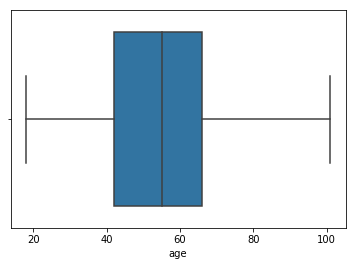

In [5]:
#the boxplot shows where the density of the data is
sns.boxplot(x=profile["age"])

The box plot shows that most of the customers are between 40 and 65 old years

##### what is the most common income amount the customers get?

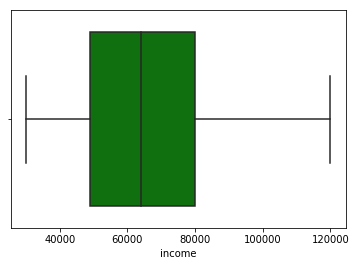

In [28]:
sns.boxplot(x=profile["income"],color='green')

In [ ]:
The box plot shows that the most common income amounts are between 50000 to 80000. 

##### Which gender is the most common?

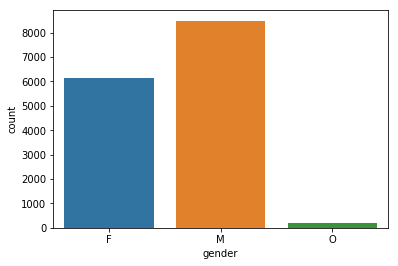

In [144]:
sns.countplot(x="gender", data=profile)

The result shows that male customers are more than females. Males are about 8500, and females are about 6000

##### which event is the most common?

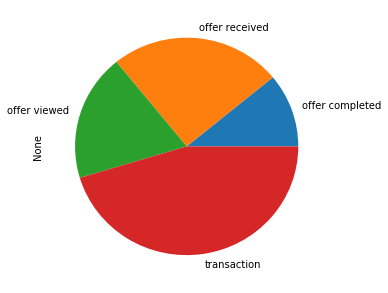

In [280]:
#a bar plot to show which event is the most common
transcript.groupby('event').size().plot(kind='pie', figsize=(5,5))

The bar plot shows that transactions are the most common events, followed by offer received, then offer viewed.

##### which offer type is the most common?

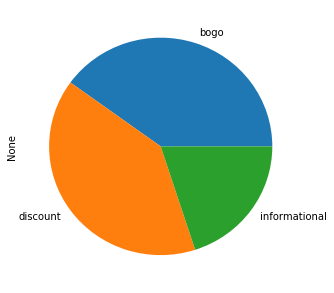

In [281]:
#bar plot to show which offer_type is the most common
portfolio.groupby('offer_type').size().plot(kind='pie', figsize=(5,5))

The bar plot shows that discount and BOGO are almost similar to each other in their counts, and they are more than informational offers.

### Investigate relationships between different variables

##### The relationship between event and offer type

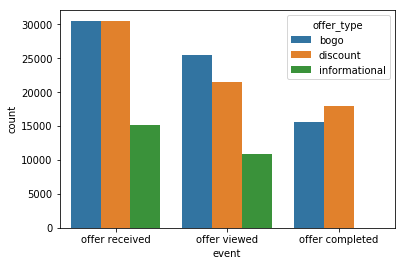

In [35]:
#check the relationship between event and offer_type
sns.countplot(x="event", hue="offer_type", data=offer_portfolio)

The count plot shows that bogo offers and discount offers are recieved equally, while informational offers has almost half of their counts. The plot also shows that bogo offers are more likely to be viewed than discount offers, and discount offers are more likely to be viewed than informational ones. However, discount offers are actually completed than bogo offers. This might be because that most of the people usually buy one product at a time, even that BOGO are more attractive but most of the customers are not intersting to buy two products if they do need. So, discount offers are preffered to them than bogo ones.  

##### The relationship between event and difficulty

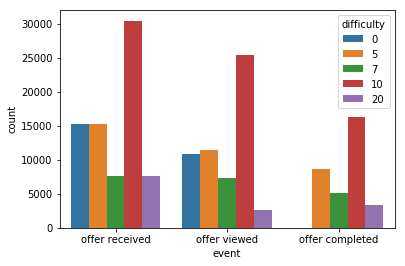

In [14]:
#check the relationship between event and difficulty
sns.countplot(x="event", hue="difficulty", data=offer_portfolio)

The plot shows that offers with 10 difficulty are the most common in all types of events. It is also notable that offers with difficulty equals to 20 are completed more than they are viewed. That might be the customers complete the offers sometimes even if they do not view or know about those offers. 

##### The relationship between the event and reward

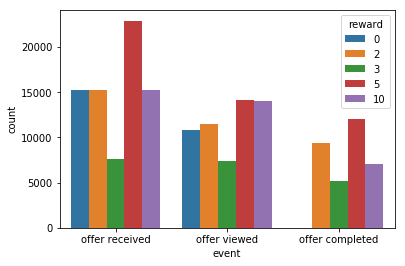

In [15]:
#check the relationship between the event and reward
sns.countplot(x="event", hue="reward", data=offer_portfolio)

The plot shows that the rewrd that are more likely to be received and completed are rewards of 5. The reward of 5 and 10 are equally viewed and they are more than other types of rewards. We also notice that rewards of 10 are viewed more than rewards of 2, but rewards of two are completed than rewards of 10. 

##### Is there a relationship between the incomes of customers and the amount they pay in transactions?

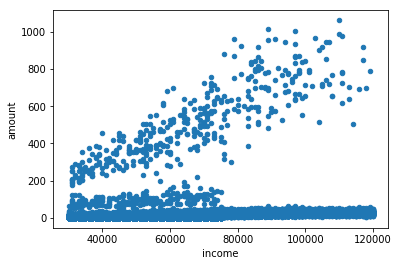

In [38]:
amount_profile[['income','amount']].plot(x= 'income', y='amount' , kind='scatter')

The scatter plot shows that there is a relationship between the customers incomes and the amount they pay. the amount increases by increasing the incomes. However, the small amounts (below 30) are payed by all customers regarding of their incomes

##### Is there a relationship between the ages of customers and the amount they pay in transactions?

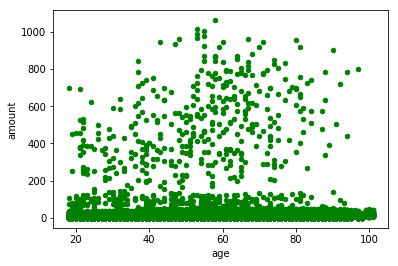

In [39]:
amount_profile[['age','amount']].plot(x= 'age', y='amount' , kind='scatter', color='green')

From the plot, there is almost no relationship between the amount and the age of the customers.

#### Is there a relationship between gender and offer type?

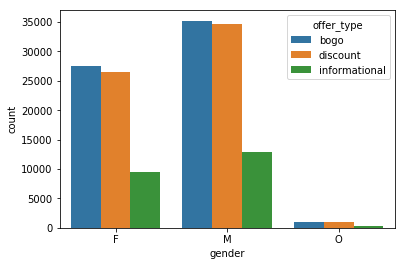

In [59]:
#plot relationship between gender and offer_type
sns.countplot(x="gender", hue="offer_type", data=profil_offer_portf)

The plot shows that all genders receive the same amount of each offer. 
So, there is no relationship between the gender and offer type.

#### Is there a relationship between gender and event of the offers?

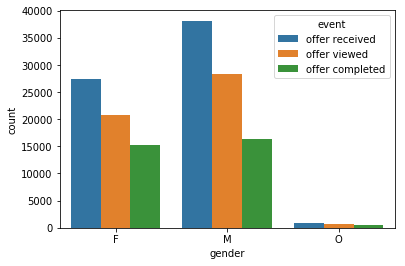

In [60]:
#plot relationship between gender and event
sns.countplot(x="gender", hue="event", data=profil_offer_portf)

The plot shows that males are more likely to receive, view and complete the offers, that is might be because their count is more than females in the dataset. However, we can notice that females are more likely to complete the offers when they view it.


## Modeling
The last part of the project is to make a simple machine learning model to classify the records into their offer type.
We start by removing person id and duplicated rows that might mislead the results.

In [54]:

#creat data for machine learning model and drop customer id because it might mislead the result
learning_df = profil_offer_portf.drop('person', axis=1).drop_duplicates()
learning_df.head()

,event,time,offer id,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,year
0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1,75.0,F,100000.0,2017.0
2,offer received,0,2906b810c7d4411798c6938adc9daaa5,10,7,discount,2,1,1,0,1,68.0,M,70000.0,2018.0
5,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,5,5,bogo,5,1,1,1,1,65.0,M,53000.0,2018.0
7,offer received,0,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,1,1,0,1,58.0,M,51000.0,2017.0
8,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,1,0,0,1,61.0,F,57000.0,2017.0


We need to normalize the numerical variables to be able to use them in the model. We use MinMaxScaler() to normalize the values between 0 and 1.

In [55]:
# create function to normalize numerical variables
def scaling(data,features):
    """
    INPUT: - the dataframe that contains variables to be normalized
           - the variables names that need to be normalized 
    OOUTPUT: a subset of the dataframe contains the normalized variables
    """
    #call MinMaxScaler and fit_transform it on the variables 
    min_max_scaler = preprocessing.MinMaxScaler()    
    x1 = data[features]
    x1 = min_max_scaler.fit_transform(x1)
    #convert the normalized numpy array to dataframe
    x1 =pd.DataFrame(x1)
    x1.columns = features

    return x1

#list of numerical variables that need to be normalized 
need_scale=['income', 'age', 'reward','time', 'duration', 'difficulty', 'year' ]

#drop the original numerical variables 
learning_df_ =learning_df.drop(need_scale,axis=1)

#concatenate the normalized variables with the dataset
learning_df=pd.concat([learning_df_, scaling(learning_df,need_scale)], axis=1,join='inner')


We also need to encode the categorical variables to be able to use them in the model. We use LabelEncoder() to encode the values into numerical values.

In [56]:
#create a function to encode categorical variables
def encode_categorical(data,feature):
    """
    INPUT: - the dataframe that contains the feature to be encoded
           - the feature name that need to be encoded 
    OOUTPUT: the dataframe contains the feature after encoding 
    """
    #call LabelEncoder and fit_transform it on the feature
    le = preprocessing.LabelEncoder()
    le = le.fit_transform(list(data[feature]))
    data[feature]=le
    return data

#list of names of features that need to be scaled
categorical_features=['gender','event','offer_type', 'offer id']

#iterate through the list of names ofcategorical features 
for f in categorical_features:
    encode_categorical(learning_df,f)

The dataset after normalizing numerical features and encoding the categorical features

In [53]:
learning_df.head()

,event,offer id,offer_type,email,mobile,social,web,gender,year,income,age,reward,time,duration,difficulty
0,1,6,0,1,1,0,1,0,2017.0,0.777778,0.686747,0.5,0.0,0.571429,0.25
2,1,2,1,1,1,0,1,1,2018.0,0.255556,0.566265,0.5,0.0,0.285714,0.25
5,1,8,0,1,1,1,1,1,2018.0,0.455556,0.530120,0.5,0.0,1.000000,1.00
7,1,3,2,1,1,0,1,1,2017.0,0.455556,0.722892,0.0,0.0,0.142857,0.00
8,1,0,1,1,0,0,1,0,2017.0,0.255556,0.843373,0.5,0.0,1.000000,1.00


Splitting the dataset to two susets, one for features and the second for the target

In [76]:
#splitting the features and the target
x=learning_df.drop(['offer_type'], axis=1) 
y=learning_df['offer_type']

Splitting the features and the target into training and testing sets.

In [77]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


We compared three different classifiers, Gaussian Naive Bayes, decision trees and logistic regression

The first classifier 'Gaussian Naive Bayes'

In [78]:
#call GaussianNB classifier and fit on the training set 
nb = GaussianNB()
nb.fit(X_train, y_train)

#predict the test set
pred = nb.predict(X_test)

#calculate the accuracy
NB_scores=accuracy_score(pred, y_test)
print("Accuracy of Naive-Bayes classifier = %0.2f  " % (NB_scores.mean() ))

Accuracy of Naive-Bayes classifier = 0.71  


The second classifier 'decision tree'

In [81]:
#call DecisionTree classifier and fit on the training set 
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)

#predict the test set
pred = decision_tree.predict(X_test)

#calculate the accuracy
DT_scores=accuracy_score(pred, y_test)
print("Accuracy of Decision Tree classifier = %0.2f  " % (DT_scores.mean() ))

Accuracy of Decision Tree classifier = 1.00  


The third classifier 'logistic regression'

In [82]:
#call LogisticRegression classifier and fit on the training set 
logRegress= LogisticRegression(random_state=1) 
reg.fit(X_train, y_train)

#predict the test set
pred = reg.predict(X_test)

#calculate the accuracy
logReg_scores=accuracy_score(pred, y_test)
print("Accuracy of Logistic Regression classifier = %0.2f  " % (logReg_scores.mean() ))

Accuracy of Logistic Regression classifier = 0.65  
